Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
#path_to_image = 'data/sr/zebra_GT.png'
path_to_image = 'data/sr/49.jpg'

# Load image and baselines

HR and LR resolutions: (128, 128), (32, 32)


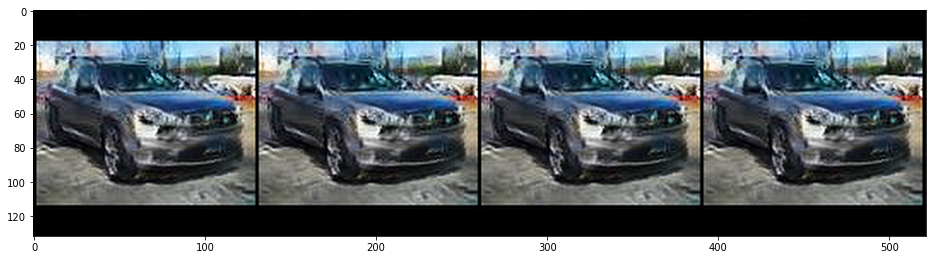

C:\Users\rmccr\Anaconda3\lib\site-packages\skimage\measure\simple_metrics.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


PSNR bicubic: inf   PSNR nearest: inf


In [2]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

imgs['bicubic_np'] = imgs['HR_np']
imgs['sharp_np'] = imgs['HR_np']
imgs['nearest_np'] = imgs['HR_np']

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [3]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.005
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [4]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [5]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


C:\Users\rmccr\Anaconda3\lib\site-packages\torch\nn\functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


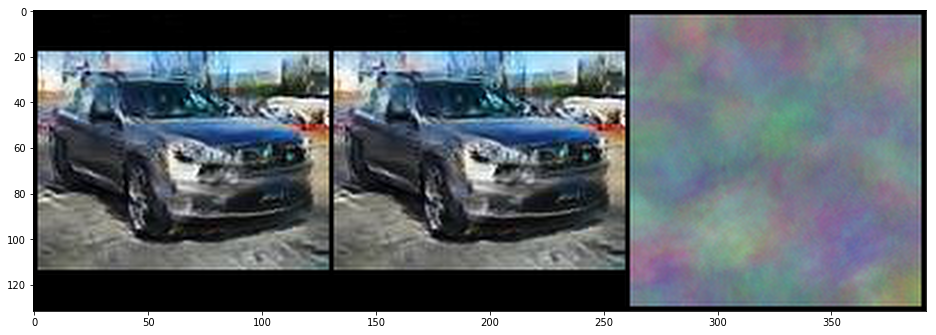

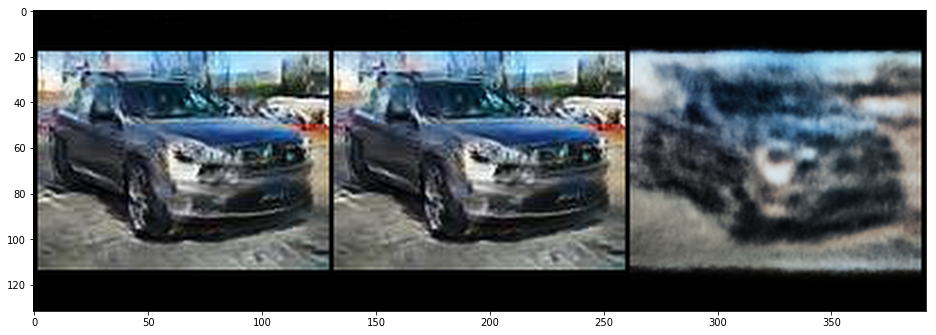

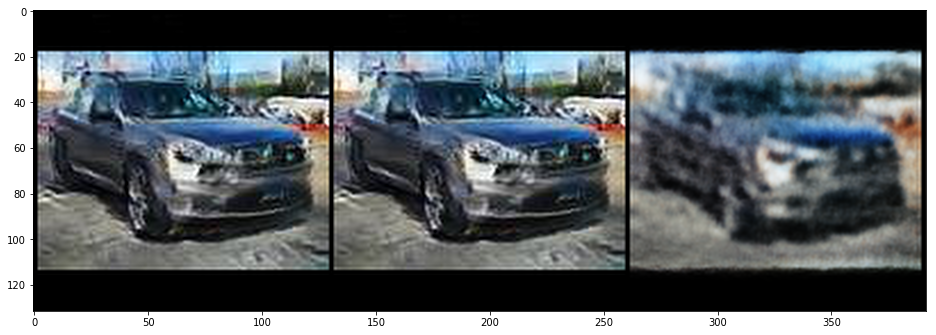

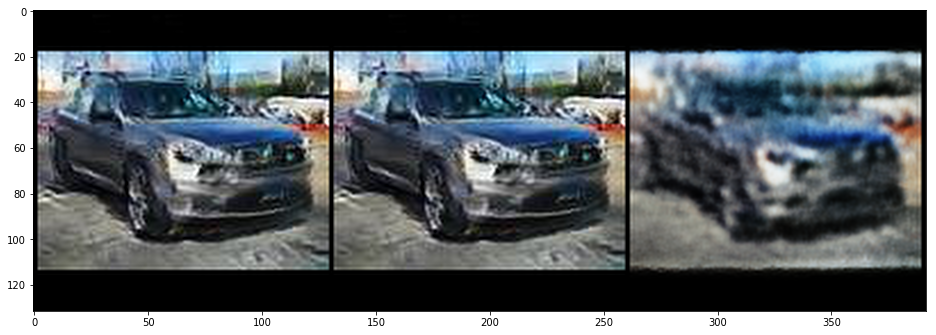

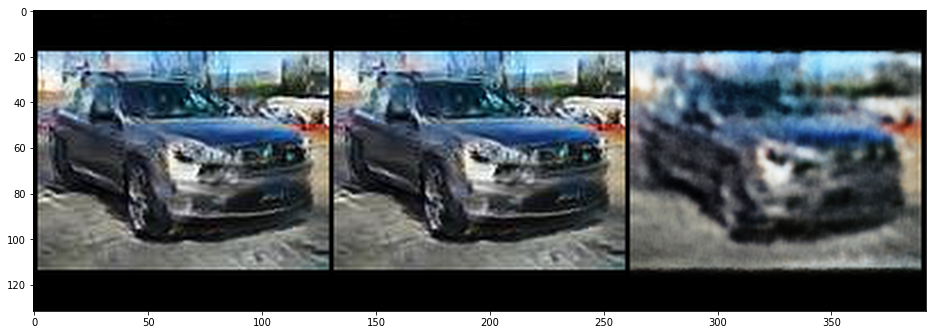

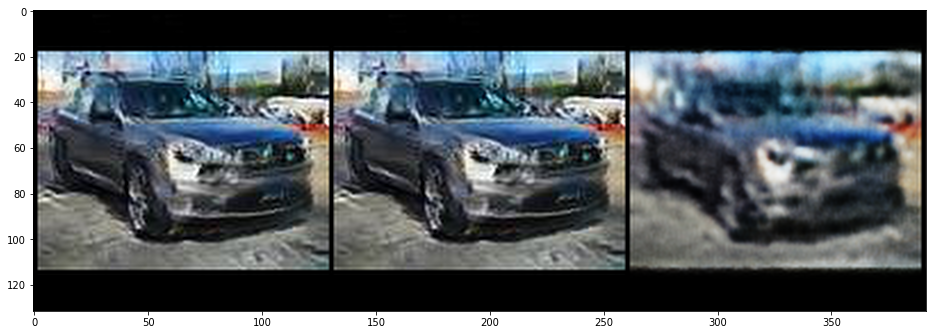

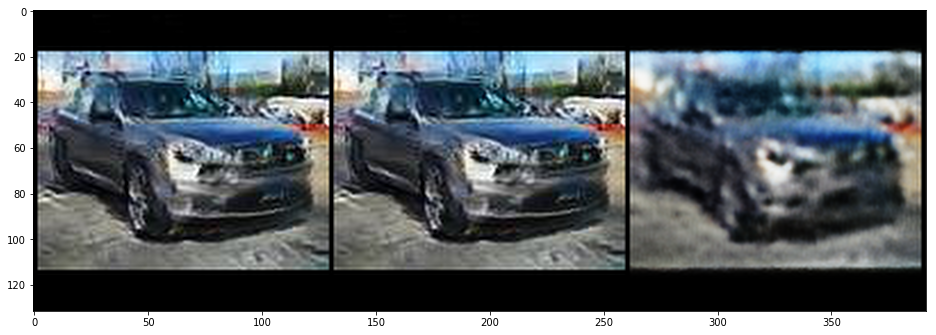

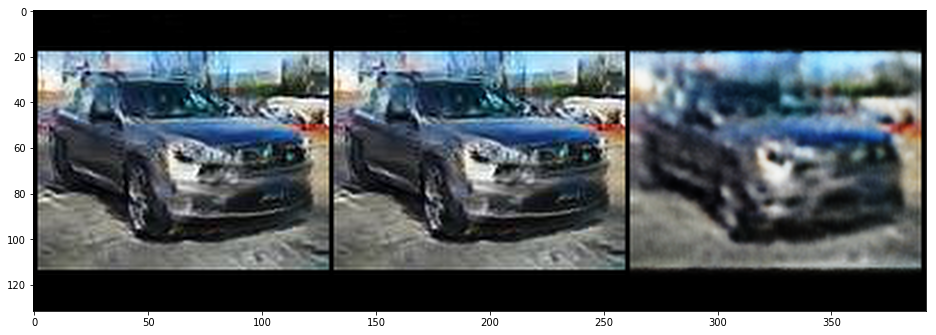

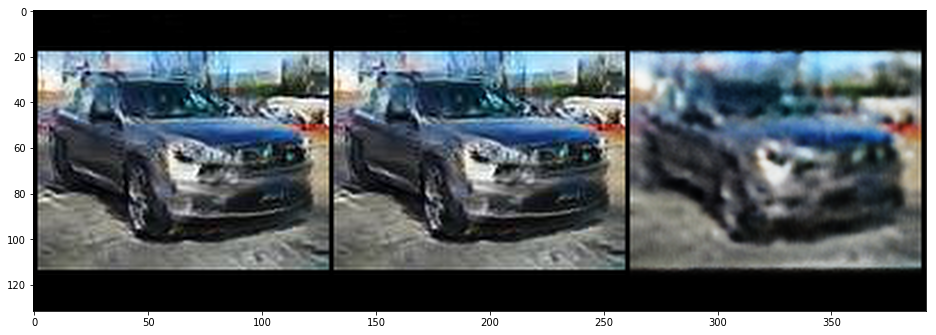

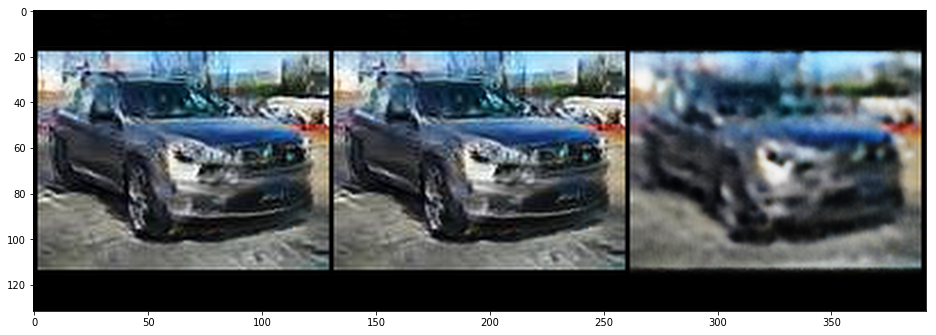

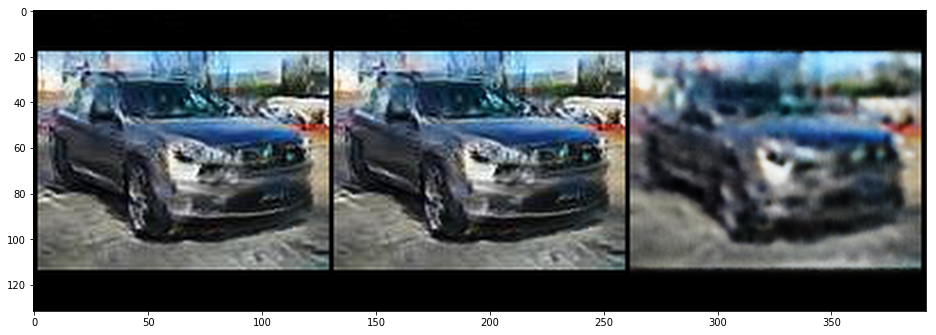

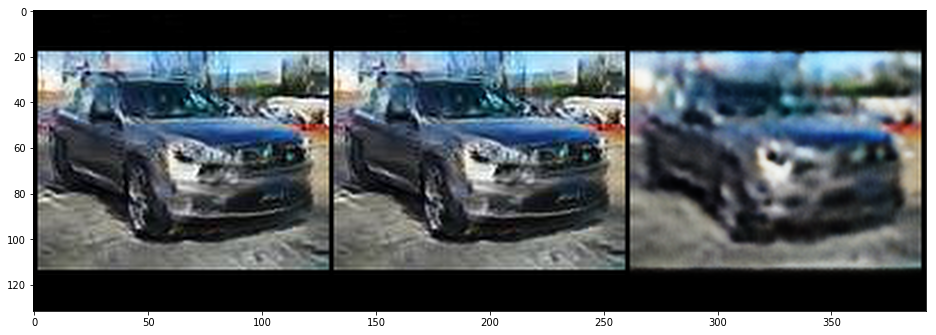

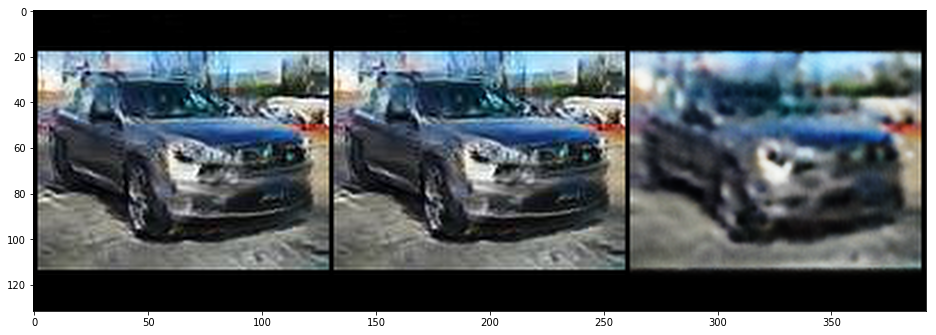

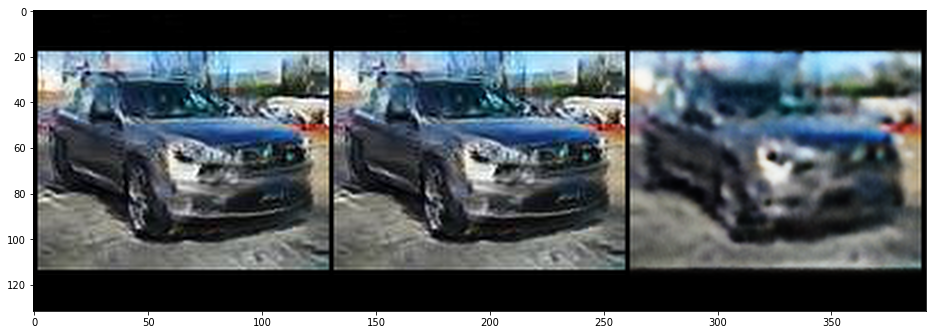

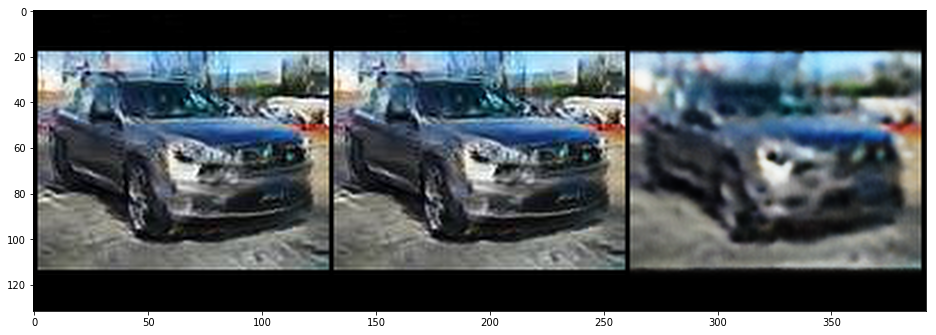

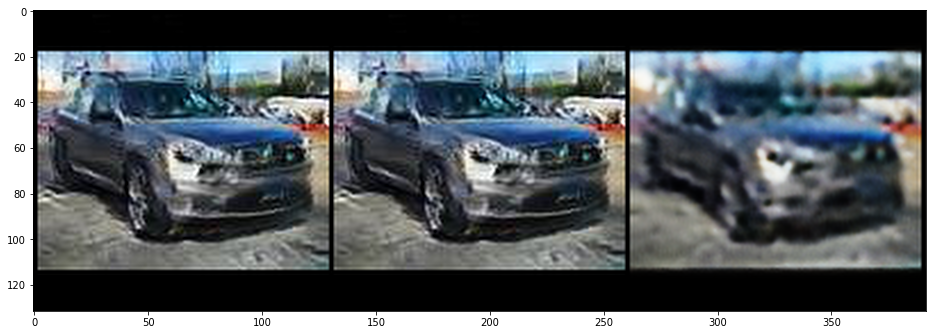

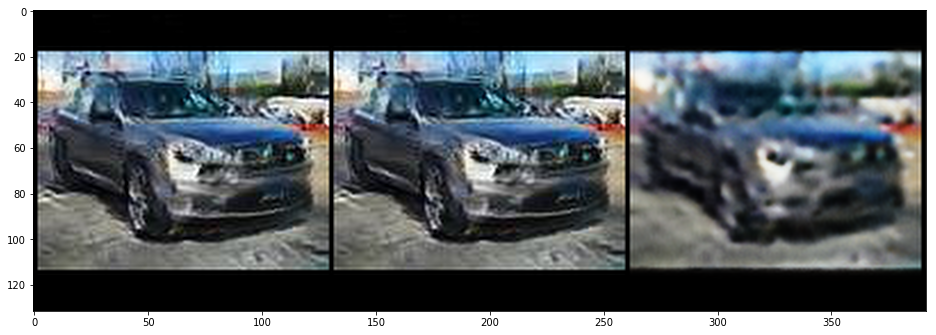

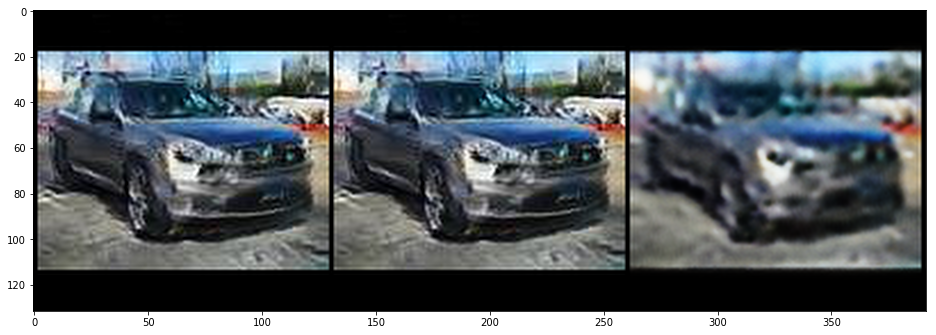

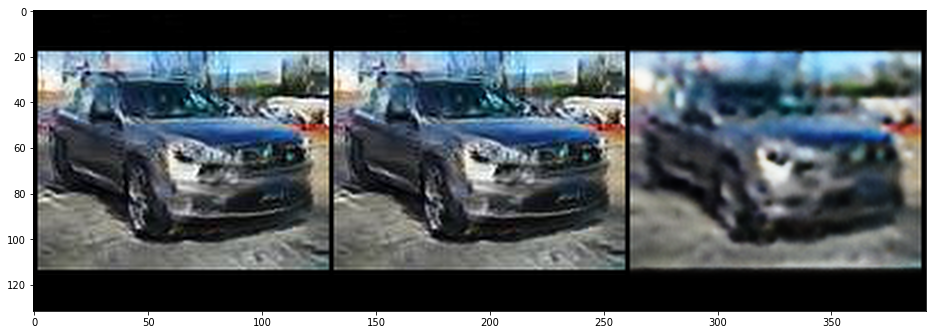

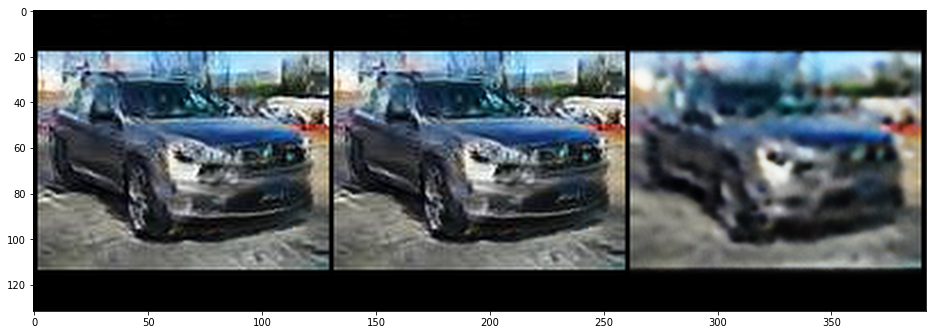

In [6]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

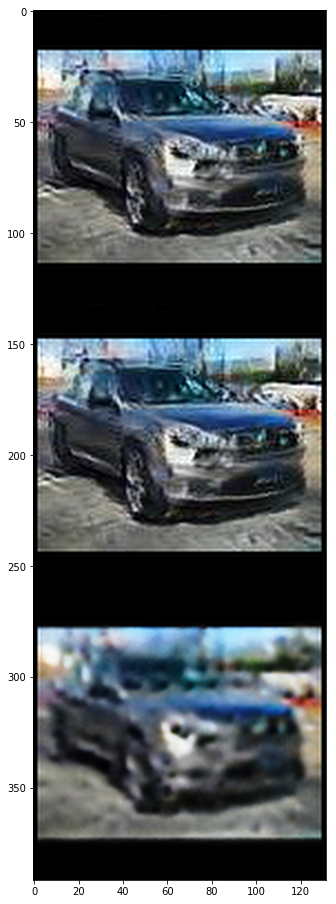

In [7]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

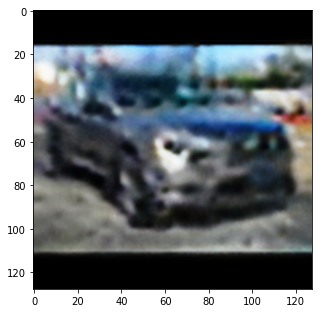

array([[[9.95099108e-05, 9.65063809e-05, 9.70182155e-05, ...,
         2.53861654e-04, 2.58922140e-04, 2.41722257e-04],
        [8.95652483e-05, 8.61979497e-05, 9.23787447e-05, ...,
         2.60009896e-04, 2.69799231e-04, 2.60026223e-04],
        [8.12529688e-05, 9.19648592e-05, 7.94712396e-05, ...,
         3.09340947e-04, 2.96297309e-04, 3.05379479e-04],
        ...,
        [6.58136050e-05, 6.66268752e-05, 7.23870326e-05, ...,
         1.24967934e-04, 1.20333803e-04, 1.25711929e-04],
        [6.61356607e-05, 6.67493587e-05, 6.88572982e-05, ...,
         1.17028758e-04, 1.14113893e-04, 1.17788732e-04],
        [7.08663792e-05, 8.02643917e-05, 7.78918329e-05, ...,
         1.26741012e-04, 1.20331722e-04, 1.24459650e-04]],

       [[6.87654319e-05, 6.61593149e-05, 7.00035525e-05, ...,
         1.84936143e-04, 1.88922801e-04, 1.79714305e-04],
        [6.31874282e-05, 5.86569513e-05, 6.56468692e-05, ...,
         1.89889339e-04, 2.00875787e-04, 1.92520427e-04],
        [5.41860245e-05, 

In [8]:
plot_image_grid([out_HR_np],factor=4, nrow=1)